In [2]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
df = pd.read_csv('EndpointLogs.csv')
features_we_care_about = ['CommandLine', 'Image', 'ParentCommandLine', 'ParentImage', 'User', 'Computer Name', 'CurrentDirectory']
df = df[features_we_care_about]
df.shape

(628144, 7)

In [4]:
df_no_duplicates = df.drop_duplicates()
df_no_duplicates.head()

,CommandLine,Image,ParentCommandLine,ParentImage,User,Computer Name,CurrentDirectory
0,"""C:\Windows\system32\cmd.exe"" /c ""C:\Program F...",C:\Windows\System32\cmd.exe,"""C:\Program Files\Microsoft Monitoring Agent\A...",C:\Program Files\Microsoft Monitoring Agent\Ag...,NT AUTHORITY\SYSTEM,MKM45.Milkyway.net,C:\Program Files\Microsoft Monitoring Agent\Ag...
1,"cmd.exe /d /c ""TPython\\TPython.bat"" Tools/Thr...",C:\Windows\SysWOW64\cmd.exe,"""C:\\Program Files (x86)\\Tanium\\Tanium Clien...",C:\Program Files (x86)\Tanium\Tanium Client\Ta...,NT AUTHORITY\SYSTEM,MKM45.Milkyway.net,C:\Program Files (x86)\Tanium\Tanium Client\
2,"""C:\Windows\system32\cmd.exe"" /D /c mkdir ""C:\...",C:\Windows\SysWOW64\cmd.exe,"cscript.exe ""C:\\Program Files (x86)\\Tanium\\...",C:\Windows\SysWOW64\cscript.exe,NT AUTHORITY\SYSTEM,MKM45.Milkyway.net,C:\Program Files (x86)\Tanium\Tanium Client\
3,"C:\Windows\system32\cmd.exe /c """"C:\Program Fi...",C:\Windows\SysWOW64\cmd.exe,"""C:\Program Files (x86)\Tanium\Tanium Client\T...",C:\Program Files (x86)\Tanium\Tanium Client\Ta...,NT AUTHORITY\SYSTEM,MKM45.Milkyway.net,C:\Program Files (x86)\Tanium\Tanium Client\
4,"""C:\Windows\system32\cmd.exe"" /c ""C:\Program F...",C:\Windows\System32\cmd.exe,"""C:\Program Files\Microsoft Monitoring Agent\A...",C:\Program Files\Microsoft Monitoring Agent\Ag...,NT AUTHORITY\SYSTEM,MKM45.Milkyway.net,C:\Program Files\Microsoft Monitoring Agent\Ag...


In [5]:
df.dtypes

CommandLine          object
Image                object
ParentCommandLine    object
ParentImage          object
User                 object
Computer Name        object
CurrentDirectory     object
dtype: object

In [9]:

import warnings
warnings.filterwarnings('ignore')

# Select relevant features
features = ['CommandLine', 'Image', 'ParentImage', 'CurrentDirectory']
data = df_no_duplicates
data = data[features]

data.dropna(inplace=True)

# Encode categorical variables
label_encoders = {}
for col in features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
X_train, X_test = train_test_split(data_normalized, test_size=0.2, random_state=42)

# Autoencoder Model
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = autoencoder.fit(X_train, X_train,
                          epochs=100,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2,
                          callbacks=[early_stopping])

# Evaluate the model
reconstructions = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.power(X_test - reconstructions, 2), axis=1)

threshold = np.percentile(reconstruction_errors, 95)  

anomalies = reconstruction_errors > threshold
anomaly_indices = np.where(anomalies)[0]
anomalous_data = df_no_duplicates.iloc[anomaly_indices]

anomalous_data.reset_index(drop=True, inplace=True)
anomalous_data[['CommandLine', 'Image', 'ParentImage', 'ParentCommandLine', 'CurrentDirectory']]


Epoch 1/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.8776 - val_loss: 0.7653
Epoch 2/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7823 - val_loss: 0.7597
Epoch 3/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7810 - val_loss: 0.7593
Epoch 4/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7806 - val_loss: 0.7589
Epoch 5/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7804 - val_loss: 0.7587
Epoch 6/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7803 - val_loss: 0.7587
Epoch 7/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7803 - val_loss: 0.7587
Epoch 8/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7802 - val_loss: 0.7586
Epoch 9/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7802 - val_loss: 0.7586
Epoch 10/100
1571/1571 [==============================] - 2s 1ms/step - l

,CommandLine,Image,ParentImage,ParentCommandLine,CurrentDirectory
0,"cmd.exe /d /c """"C:\Program Files (x86)\Tanium...",C:\Windows\SysWOW64\cmd.exe,C:\Windows\SysWOW64\cmd.exe,"C:\Windows\system32\cmd.exe /d /c ""cmd.exe /d ...",C:\Program Files (x86)\Tanium\Tanium Client\
1,"""C:\Windows\system32\cmd.exe"" /c ""C:\Program F...",C:\Windows\System32\cmd.exe,C:\Program Files\Microsoft Monitoring Agent\Ag...,"""C:\Program Files\Microsoft Monitoring Agent\A...",C:\Program Files\Microsoft Monitoring Agent\Ag...
2,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,"""C:\Program Files (x86)\Microsoft\Edge\Applica...",C:\Program Files\Snow Software\Inventory\Agent\
3,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,"""C:\Program Files (x86)\Microsoft\Edge\Applica...",C:\Program Files\Snow Software\Inventory\Agent\
4,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,"""C:\Program Files (x86)\Microsoft\Edge\Applica...",C:\Program Files\Snow Software\Inventory\Agent\
...,...,...,...,...,...
6277,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files\Google\Chrome\Application\chr...,"""C:\Program Files\Google\Chrome\Application\ch...",C:\ProgramData\Symantec\Symantec Endpoint Prot...
6278,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files\Google\Chrome\Application\chr...,"""C:\Program Files\Google\Chrome\Application\ch...",C:\ProgramData\Symantec\Symantec Endpoint Prot...
6279,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files\Google\Chrome\Application\chr...,"""C:\Program Files\Google\Chrome\Application\ch...",C:\ProgramData\Symantec\Symantec Endpoint Prot...
6280,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,"""C:\Program Files (x86)\Microsoft\Edge\Applica...",C:\Program Files\Snow Software\Inventory\Agent\


In [10]:
# Load the data
data = pd.read_csv('EndpointLogs.csv')

# Select relevant features
features = ['CommandLine', 'Image', 'ParentImage', 'CurrentDirectory']
data = data[features]

data.dropna(inplace=True)

# Encode categorical variables
label_encoders = {}
for col in features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
X_train, X_test = train_test_split(data_normalized, test_size=0.2, random_state=42)

# Autoencoder Model
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = autoencoder.fit(X_train, X_train,
                          epochs=100,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2,
                          callbacks=[early_stopping])

# Evaluate the model
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

# Define your threshold
threshold = np.mean(mse) + 2 * np.std(mse)

# Predict anomalies
anomaly_indices = np.where(mse > threshold)[0]
anomalies = data.iloc[anomaly_indices].copy()

for col in features:
    anomalies[col] = label_encoders[col].inverse_transform(anomalies[col].astype(int))

anomalies.reset_index(drop=True, inplace=True)

anomalies[['CommandLine', 'Image', 'ParentImage', 'CurrentDirectory']]

Epoch 1/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.8520 - val_loss: 0.7754
Epoch 2/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7901 - val_loss: 0.7693
Epoch 3/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7862 - val_loss: 0.7656
Epoch 4/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7850 - val_loss: 0.7654
Epoch 5/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7849 - val_loss: 0.7653
Epoch 6/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7848 - val_loss: 0.7653
Epoch 7/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7848 - val_loss: 0.7653
Epoch 8/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7827 - val_loss: 0.7617
Epoch 9/100
1571/1571 [==============================] - 2s 1ms/step - loss: 0.7813 - val_loss: 0.7616
Epoch 10/100
1571/1571 [==============================] - 2s 1ms/step - l

,CommandLine,Image,ParentImage,CurrentDirectory
0,"C:\Windows\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files\Google\Chrome\Application\chr...,C:\ProgramData\Symantec\Symantec Endpoint Prot...
1,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,C:\Program Files\Snow Software\Inventory\Agent\
2,"C:\Windows\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files\Google\Chrome\Application\chr...,C:\ProgramData\Symantec\Symantec Endpoint Prot...
3,C:\Windows\system32\cmd.exe /c tasklist /svc >...,C:\Windows\System32\cmd.exe,C:\Program Files\VERITAS\NetBackup\bin\nbdisco...,C:\Windows\system32\
4,"""C:\Windows\system32\cmd.exe"" /c ""C:\Program F...",C:\Windows\System32\cmd.exe,C:\Program Files\Microsoft Monitoring Agent\Ag...,C:\Program Files\Microsoft Monitoring Agent\Ag...
...,...,...,...,...
551,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files\Google\Chrome\Application\chr...,C:\ProgramData\Symantec\Symantec Endpoint Prot...
552,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,C:\Program Files\Snow Software\Inventory\Agent\
553,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,C:\Program Files\Snow Software\Inventory\Agent\
554,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,C:\Program Files\Snow Software\Inventory\Agent\


In [11]:
anomalies

,CommandLine,Image,ParentImage,CurrentDirectory
0,"C:\Windows\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files\Google\Chrome\Application\chr...,C:\ProgramData\Symantec\Symantec Endpoint Prot...
1,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,C:\Program Files\Snow Software\Inventory\Agent\
2,"C:\Windows\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files\Google\Chrome\Application\chr...,C:\ProgramData\Symantec\Symantec Endpoint Prot...
3,C:\Windows\system32\cmd.exe /c tasklist /svc >...,C:\Windows\System32\cmd.exe,C:\Program Files\VERITAS\NetBackup\bin\nbdisco...,C:\Windows\system32\
4,"""C:\Windows\system32\cmd.exe"" /c ""C:\Program F...",C:\Windows\System32\cmd.exe,C:\Program Files\Microsoft Monitoring Agent\Ag...,C:\Program Files\Microsoft Monitoring Agent\Ag...
...,...,...,...,...
551,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files\Google\Chrome\Application\chr...,C:\ProgramData\Symantec\Symantec Endpoint Prot...
552,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,C:\Program Files\Snow Software\Inventory\Agent\
553,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,C:\Program Files\Snow Software\Inventory\Agent\
554,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,C:\Program Files\Snow Software\Inventory\Agent\


In [12]:
anomalies['CommandLine'][0]

'C:\\Windows\\system32\\cmd.exe /d /s /c ""C:\\ProgramData\\Symantec\\Symantec Endpoint Protection\\14.3.7393.4000.105\\Data\\Definitions\\WebExtDefs\\20230508.003\\webextbridge.exe" chrome-extension://hjhklbomhmbfockimpldchgpbnccmbgp/ --parent-window=0" < \\\\.\\pipe\\chrome.nativeMessaging.in.b52f95a55d8238f1 > \\\\.\\pipe\\chrome.nativeMessaging.out.b52f95a55d8238f1'

In [13]:
# Load the data
data = pd.read_csv('EndpointLogs.csv')

features = ['CommandLine', 'Image', 'ParentImage', 'CurrentDirectory']
data = data[features]
data.dropna(inplace=True)

label_encoders = {}
for col in features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

X_train, X_test = train_test_split(data_normalized, test_size=0.2, random_state=42)

# Autoencoder Model
input_dim = X_train.shape[1]
encoding_dim = 12

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='selu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='selu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='selu')(encoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2,
                          callbacks=[early_stopping])

# Evaluate the model
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

threshold = np.mean(mse) + 2 * np.std(mse)

# Predict anomalies
anomaly_indices = np.where(mse > threshold)[0]
anomalies = data.iloc[anomaly_indices].copy()

for col in features:
    anomalies[col] = label_encoders[col].inverse_transform(anomalies[col].astype(int))

anomalies.reset_index(drop=True, inplace=True)

anomalies[['CommandLine', 'Image', 'ParentImage', 'CurrentDirectory']]

Epoch 1/50
1571/1571 [==============================] - 2s 1ms/step - loss: 0.8605 - val_loss: 0.8231
Epoch 2/50
1571/1571 [==============================] - 2s 1ms/step - loss: 0.8423 - val_loss: 0.8217
Epoch 3/50
1571/1571 [==============================] - 2s 1ms/step - loss: 0.8417 - val_loss: 0.8215
Epoch 4/50
1571/1571 [==============================] - 2s 1ms/step - loss: 0.8416 - val_loss: 0.8213
Epoch 5/50
1571/1571 [==============================] - 2s 1ms/step - loss: 0.8414 - val_loss: 0.8212
Epoch 6/50
1571/1571 [==============================] - 2s 1ms/step - loss: 0.8414 - val_loss: 0.8212
Epoch 7/50
1571/1571 [==============================] - 2s 1ms/step - loss: 0.8413 - val_loss: 0.8211
Epoch 8/50
1571/1571 [==============================] - 2s 1ms/step - loss: 0.8413 - val_loss: 0.8211
Epoch 9/50
1571/1571 [==============================] - 2s 1ms/step - loss: 0.8413 - val_loss: 0.8211
Epoch 10/50
1571/1571 [==============================] - 2s 1ms/step - loss: 0.841

,CommandLine,Image,ParentImage,CurrentDirectory
0,"C:\Windows\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files\Google\Chrome\Application\chr...,C:\ProgramData\Symantec\Symantec Endpoint Prot...
1,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,C:\Program Files\Snow Software\Inventory\Agent\
2,"C:\Windows\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files\Google\Chrome\Application\chr...,C:\ProgramData\Symantec\Symantec Endpoint Prot...
3,C:\Windows\system32\cmd.exe /c tasklist /svc >...,C:\Windows\System32\cmd.exe,C:\Program Files\VERITAS\NetBackup\bin\nbdisco...,C:\Windows\system32\
4,"""C:\Windows\system32\cmd.exe"" /c ""C:\Program F...",C:\Windows\System32\cmd.exe,C:\Program Files\Microsoft Monitoring Agent\Ag...,C:\Program Files\Microsoft Monitoring Agent\Ag...
...,...,...,...,...
638,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,C:\Program Files\Snow Software\Inventory\Agent\
639,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,C:\Program Files\Snow Software\Inventory\Agent\
640,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Microsoft\Edge\Applicat...,C:\Program Files\Snow Software\Inventory\Agent\
641,"C:\WINDOWS\system32\cmd.exe /d /s /c """"C:\Prog...",C:\Windows\System32\cmd.exe,C:\Program Files (x86)\Google\Chrome\Applicati...,C:\Program Files\Snow Software\Inventory\Agent\


In [14]:
anomalies['CommandLine'][0]

'C:\\Windows\\system32\\cmd.exe /d /s /c ""C:\\ProgramData\\Symantec\\Symantec Endpoint Protection\\14.3.7393.4000.105\\Data\\Definitions\\WebExtDefs\\20230508.003\\webextbridge.exe" chrome-extension://hjhklbomhmbfockimpldchgpbnccmbgp/ --parent-window=0" < \\\\.\\pipe\\chrome.nativeMessaging.in.b52f95a55d8238f1 > \\\\.\\pipe\\chrome.nativeMessaging.out.b52f95a55d8238f1'

<br/>

## You can't be tired just yet
## I heard someone saying "More Jupyter Please!"


<br/>

In [15]:
# Load the data
data = pd.read_csv('calderaeid1.csv')
data.shape


(9100, 11)

In [18]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from joblib import dump

df = data

df = df.fillna('')

df['combined_features'] = df['Image'] + ' ' + df['CommandLine'] + ' ' + df['CurrentDirectory'] + ' ' + df['ParentCommandLine']

# Feature extraction
X = df['combined_features']
y = df['is_malicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Text vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Training random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

# Save the model and the vectorizer
dump(clf, 'malicious_commandline_detection_model.joblib')
dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')



              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1584
           1       0.98      0.84      0.90       236

    accuracy                           0.98      1820
   macro avg       0.98      0.92      0.95      1820
weighted avg       0.98      0.98      0.98      1820



['tfidf_vectorizer.joblib']

### Time to test the Model

In [19]:
import pandas as pd
from joblib import load

# Load the model and vectorizer
clf = load('malicious_commandline_detection_model.joblib')
tfidf_vectorizer = load('tfidf_vectorizer.joblib')

new_df = pd.read_csv('calderaeid2.csv')

new_df = new_df.fillna('')

new_df['combined_features'] = new_df['Image'] + ' ' + new_df['CommandLine'] + ' ' + new_df['CurrentDirectory'] + ' ' + new_df['ParentCommandLine']

# Extract features for prediction
X_new = new_df['combined_features']

# Transform the new data
X_new_tfidf = tfidf_vectorizer.transform(X_new)

# Make predictions
predictions = clf.predict(X_new_tfidf)
new_df['is_malicious'] = predictions

# Display the results
new_df[['CommandLine', 'is_malicious']]


,CommandLine,is_malicious
0,"""taskkill.exe"" /f /im ""UltraViewer_Service.exe""",1
1,"""taskkill.exe"" /f /im ""UltraViewer_Desktop.exe""",1
2,"""taskkill.exe"" /f /im ""UltraViewer_Desktop.exe""",1
3,"""C:\Windows\Microsoft.NET\Framework\v4.0.30319...",1
4,"""C:\Windows\Microsoft.NET\Framework\v4.0.30319...",0
...,...,...
74,"""C:\Windows\system32\net.exe"" user NewLocalUser",1
75,C:\Windows\system32\net1 user NewLocalUser,0
76,"""powershell.exe"" & {$wdApp = New-Object -COMOb...",0
77,"""C:\Program Files (x86)\Microsoft Office\Root\...",0


<br/>

## I just heard someone saying something about UNSUPERVISED ML

<br/>

Epoch 1/50
29/29 [==============================] - 1s 8ms/step - loss: 0.6724 - val_loss: 0.6185
Epoch 2/50
29/29 [==============================] - 0s 5ms/step - loss: 0.5313 - val_loss: 0.3765
Epoch 3/50
29/29 [==============================] - 0s 5ms/step - loss: 0.2911 - val_loss: 0.1660
Epoch 4/50
29/29 [==============================] - 0s 5ms/step - loss: 0.1351 - val_loss: 0.0841
Epoch 5/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0749 - val_loss: 0.0558
Epoch 6/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0518 - val_loss: 0.0438
Epoch 7/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0411 - val_loss: 0.0377
Epoch 8/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0353 - val_loss: 0.0340
Epoch 9/50
29/29 [==============================] - 0s 4ms/step - loss: 0.0317 - val_loss: 0.0316
Epoch 10/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0294 - val_loss: 0.0300
Epoch 11/50
29/29 [

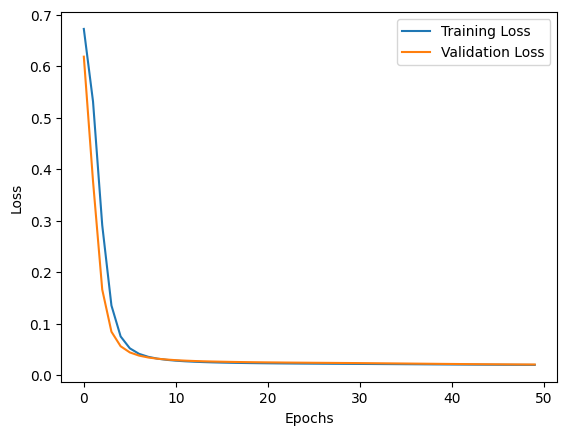

285/285 [==============================] - 0s 926us/step


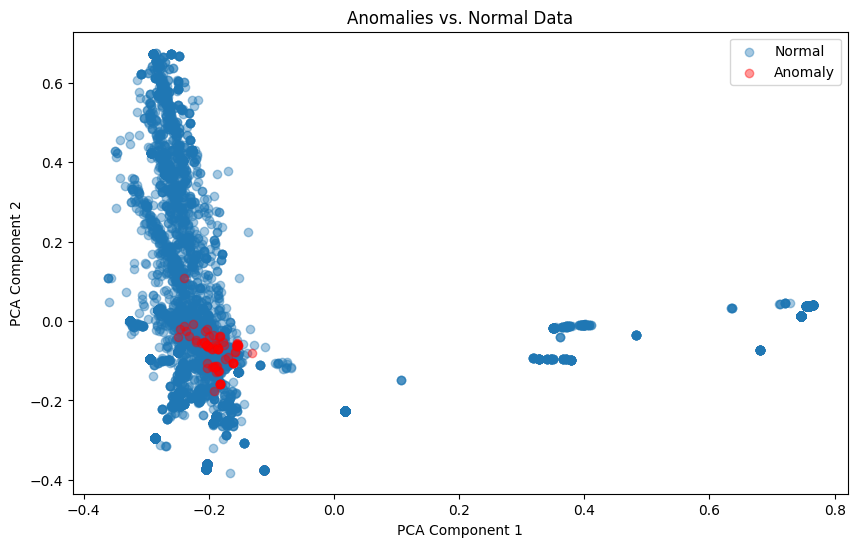

,CommandLine,is_anomaly
0,"""powershell.exe"" & {$wdApp = New-Object -COMOb...",0
1,notepad.exe,0
2,C:\Users\JOHNNY~1\AppData\Local\Temp\tcm.tmp ...,0
3,"""cmd.exe"" /c copy %%windir%%\system32\certutil...",0
4,C:\Users\JOHNNY~1\AppData\Local\Temp\tcm.tmp ...,0
...,...,...
9095,"""C:\Program Files\Microsoft OneDrive\24.086.04...",0
9096,C:\Windows\servicing\TrustedInstaller.exe,0
9097,C:\Windows\winsxs\amd64_microsoft-windows-serv...,0
9098,"""C:\Program Files\Microsoft OneDrive\24.086.04...",0


In [20]:

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load data
df = pd.read_csv('calderaeid1.csv')
df = df.fillna('')

# Combine features
df['combined_features'] = df['Image'] + ' ' + df['CommandLine'] + ' ' + df['CurrentDirectory'] + ' ' + df['ParentCommandLine']
X = df['combined_features']

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_dense = X_tfidf.toarray()

# Define autoencoder
input_dim = X_dense.shape[1]
encoding_dim = 32
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train autoencoder
history = autoencoder.fit(X_dense, X_dense,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=1)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Get reconstruction error
reconstructed = autoencoder.predict(X_dense)
reconstruction_error = np.mean(np.abs(X_dense - reconstructed), axis=1)

# Set threshold and label anomalies
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
df['is_anomaly'] = (reconstruction_error > threshold).astype(int)

# Visualize anomalies
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[df['is_anomaly'] == 0, 0], X_pca[df['is_anomaly'] == 0, 1], label='Normal', alpha=0.4)
plt.scatter(X_pca[df['is_anomaly'] == 1, 0], X_pca[df['is_anomaly'] == 1, 1], label='Anomaly', alpha=0.4, color='red')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('Anomalies vs. Normal Data')
plt.show()

df[['CommandLine', 'is_anomaly']]



In [27]:
df[df['is_anomaly']==1][['CommandLine', 'is_anomaly']]


,CommandLine,is_anomaly
177,fsutil fsinfo drives,1
478,"""C:\Windows\system32\rundll32.exe"" about:""\..\...",1
522,"dsquery * -filter ""(objectClass=trustedDomain...",1
523,nltest /domain_trusts,1
525,nltest /trusted_domains,1
...,...,...
7716,nbtstat -n,1
7726,sc.exe qc wlansvc,1
7727,sc.exe queryex wlansvc,1
8691,%%ProgramFiles%%\RUXIM\RUXIMICS.EXE /nonetwork,1


Epoch 1/50
1/1 [==============================] - 0s 363ms/step - loss: 0.6939 - val_loss: 0.6928
Epoch 2/50
1/1 [==============================] - 0s 34ms/step - loss: 0.6929 - val_loss: 0.6917
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 0.6918 - val_loss: 0.6906
Epoch 4/50
1/1 [==============================] - 0s 22ms/step - loss: 0.6908 - val_loss: 0.6895
Epoch 5/50
1/1 [==============================] - 0s 22ms/step - loss: 0.6896 - val_loss: 0.6884
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 0.6886 - val_loss: 0.6873
Epoch 7/50
1/1 [==============================] - 0s 20ms/step - loss: 0.6873 - val_loss: 0.6861
Epoch 8/50
1/1 [==============================] - 0s 22ms/step - loss: 0.6861 - val_loss: 0.6849
Epoch 9/50
1/1 [==============================] - 0s 24ms/step - loss: 0.6850 - val_loss: 0.6836
Epoch 10/50
1/1 [==============================] - 0s 22ms/step - loss: 0.6838 - val_loss: 0.6823
Epoch 11/50
1/1 [===========

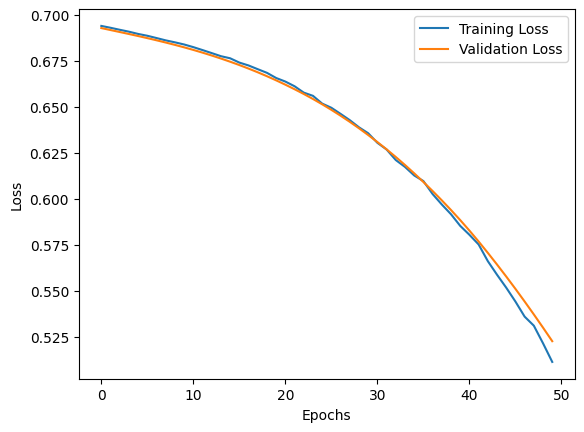

1/1 [==============================] - 0s 31ms/step


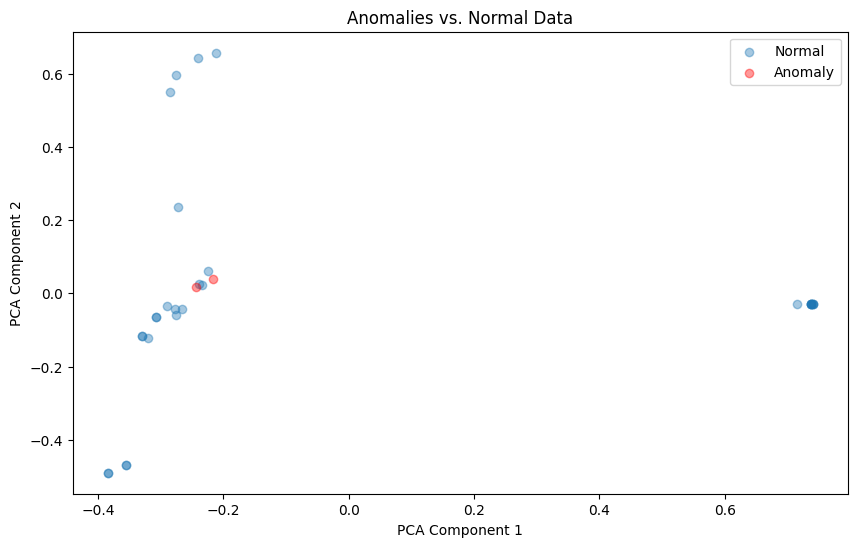

,CommandLine,is_anomaly
7345,"""C:\Windows\system32\sc.exe"" config Eaphost er...",0
7912,"""C:\windows\system32\auditpol.exe"" /get /subca...",0
8612,"""C:\windows\system32\auditpol.exe"" /get /subca...",0
2268,C:\Windows\System32\smartscreen.exe -Embedding,0
4165,"""C:\Windows\System32\WindowsPowerShell\v1.0\po...",0
4199,"""C:\Program Files (x86)\Microsoft Office\root\...",0
5843,"""C:\Program Files (x86)\Gpg4win\bin\gpgme-w32s...",0
2788,"""C:\windows\system32\auditpol.exe"" /get /subca...",0
850,C:\Windows\System32\MsiExec.exe -Embedding 2C3...,1
4715,"""C:\Program Files (x86)\Microsoft Office\Root\...",0


In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load data
df = pd.read_csv('calderaeid1.csv')
df = df.fillna('')

# Combine features
df['combined_features'] = df['Image'] + ' ' + df['CommandLine'] + ' ' + df['CurrentDirectory'] + ' ' + df['ParentCommandLine']
X = df['combined_features']

# Randomly select samples
np.random.seed(92)
random_indices = np.random.choice(X.index, size=32, replace=False)
X_sample = X[random_indices]

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(X_sample)
X_dense = X_tfidf.toarray()

# Define autoencoder
input_dim = X_dense.shape[1]
encoding_dim = 32
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
dropout = Dropout(0.1)(encoded)
decoded = Dense(input_dim, activation='sigmoid')(dropout)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train autoencoder
history = autoencoder.fit(X_dense, X_dense,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=1)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Get reconstruction error
reconstructed = autoencoder.predict(X_dense)
reconstruction_error = np.mean(np.abs(X_dense - reconstructed), axis=1)

# Set threshold and label anomalies
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
df['is_anomaly'] = 0
df.loc[random_indices, 'is_anomaly'] = (reconstruction_error > threshold).astype(int)

# Visualize anomalies
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[df.loc[random_indices, 'is_anomaly'] == 0, 0], X_pca[df.loc[random_indices, 'is_anomaly'] == 0, 1], label='Normal', alpha=0.4)
plt.scatter(X_pca[df.loc[random_indices, 'is_anomaly'] == 1, 0], X_pca[df.loc[random_indices, 'is_anomaly'] == 1, 1], label='Anomaly', alpha=0.4, color='red')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('Anomalies vs. Normal Data')
plt.show()

df.loc[random_indices, ['CommandLine', 'is_anomaly']]


In [20]:
df['CommandLine'][921]

'"cmd.exe" /c mkdir %%temp%%\\T1222.001_attrib_2 >nul 2>&1 & echo T1222.001_attrib1 >> %%temp%%\\T1222.001_attrib_2\\T1222.001_attrib1.txt & echo T1222.001_attrib2 >> %%temp%%\\T1222.001_attrib_2\\T1222.001_attrib2.txt & attrib.exe +h %%temp%%\\T1222.001_attrib_2\\T1222.001_attrib1.txt & attrib.exe +h %%temp%%\\T1222.001_attrib_2\\T1222.001_attrib2.txt'

## Extras

In [ ]:
## Extract Fields from Message(If you're getting data from Elastic)

df = data

def extract_fields(message):
    fields = {
        'Image': None,
        'OriginalFileName': None,
        'CommandLine': None,
        'CurrentDirectory': None,
        'User': None,
        'ParentImage': None,
        'ParentCommandLine': None
    }
    
    if isinstance(message, str):
        for line in message.split('\n'):
            if line.startswith('Image: '):
                fields['Image'] = line.split('Image: ')[1]
            elif line.startswith('OriginalFileName: '):
                fields['OriginalFileName'] = line.split('OriginalFileName: ')[1]
            elif line.startswith('CommandLine: '):
                fields['CommandLine'] = line.split('CommandLine: ')[1]
            elif line.startswith('CurrentDirectory: '):
                fields['CurrentDirectory'] = line.split('CurrentDirectory: ')[1]
            elif line.startswith('User: '):
                fields['User'] = line.split('User: ')[1]
            elif line.startswith('ParentImage: '):
                fields['ParentImage'] = line.split('ParentImage: ')[1]
            elif line.startswith('ParentCommandLine: '):
                fields['ParentCommandLine'] = line.split('ParentCommandLine: ')[1]
    
    return pd.Series(fields)

extracted_df = df['message'].apply(extract_fields)

df = pd.concat([df, extracted_df], axis=1)

df.drop(columns=['message'], inplace=True)

df 